# Overview
The notebook is setup to reproduce some of the results published by MIT in https://arxiv.org/pdf/1802.02604.pdf and made popular in media sites like: https://www.healthdatamanagement.com/news/mit-algorithm-speeds-process-of-image-registration

The challenge here is to see how the results look on their test datasets and see how the performance is using K80 GPU's provided by Kaggle. Furthre notebooks could go and compare these results to those from standard approaches using ITK/SimpleITK and even OpenCV-based image registration

In [1]:
%matplotlib inline
import os, sys
import glob

# third party
import tensorflow as tf
import scipy.io as sio
import numpy as np
from keras.backend.tensorflow_backend import set_session
from scipy.interpolate import interpn
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
print(sys.path)

['', '/Library/Frameworks/Python.framework/Versions/3.6/lib/python36.zip', '/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6', '/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/lib-dynload', '/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages', '/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/extensions', '/Users/lalithnag/.ipython']


In [96]:
sys.path.remove('/Users/lalithnag/00-code/voxelmorph/ext/neuron')

In [3]:
vm_dir = '/Users/lalithnag/00-code/voxelmorph/ct_scans/voxelmorph-master'
sys.path.append(os.path.join(vm_dir, 'src')) # add source

# add all folders under ../ext directory
sys.path.append(os.path.join(vm_dir, 'ext', 'medipy-lib'))
#sys.path.append(os.path.join(vm_dir, 'ext', 'neuron'))
#sys.path.append(os.path.join(vm_dir, 'ext', 'pynd-lib'))
#sys.path.append(os.path.join(vm_dir, 'ext', 'pytools-lib'))


In [4]:
import medipy
import networks
from medipy.metrics import dice

import datagenerators

# Setup the Network
The network is designed for specific dimensions and in particular the pretrained values expect these dimensions and kernel count. If we want to use it without retrainined we are forced to stick to these sizes / depths

In [5]:
# params for the vm2 model
vol_size=(160,192,224)
nf_enc=[16,32,32,32]
nf_dec=[32,32,32,32,32,16,16,3]

# Load Atlas Data
Here is the atlas dataset that we load as our reference or fixed-image against which we register everything else. We load the labels as well since they help with the DICE scoring later.

In [6]:
# Anatomical labels we want to evaluate
labels = sio.loadmat(os.path.join(vm_dir, 'data', 'labels.mat'))['labels'][0]

In [7]:
atlas = np.load(os.path.join(vm_dir, 'data', 'atlas_norm.npz'))
atlas_vol = atlas['vol']
atlas_seg = atlas['seg']
atlas_vol = np.expand_dims(np.expand_dims(atlas_vol, 0), -1)
print(atlas_vol.shape, atlas_seg.shape)

(1, 160, 192, 224, 1) (160, 192, 224)


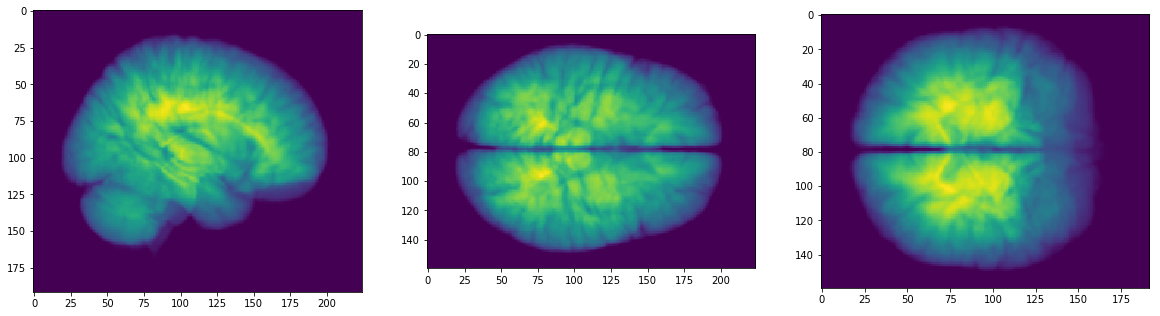

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 10))
ax1.imshow(np.mean(atlas_vol[0, :, :, :, 0], 0))
ax2.imshow(np.mean(atlas_vol[0, :, :, :, 0], 1))
ax3.imshow(np.mean(atlas_vol[0, :, :, :, 0], 2))

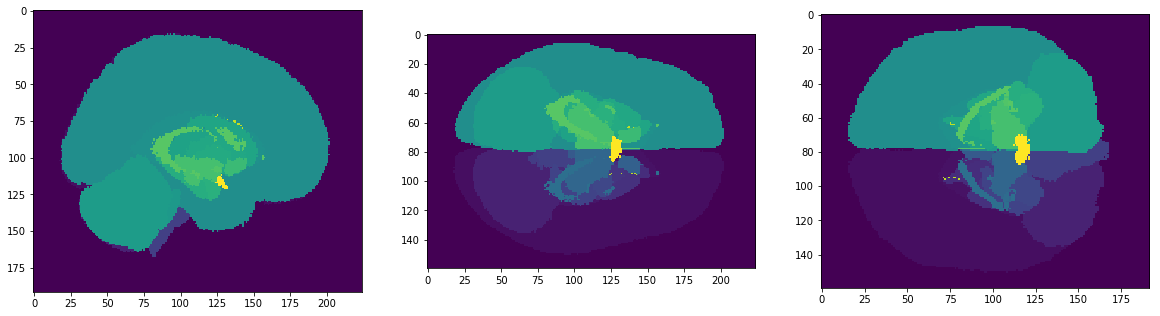

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 10))
ax1.imshow(np.max(atlas_seg, 0))
ax2.imshow(np.max(atlas_seg, 1))
ax3.imshow(np.max(atlas_seg, 2))

# Load the Model
Here we create the model and load in the pretrained weights

In [10]:
net = networks.unet(vol_size, nf_enc, nf_dec)
net.load_weights(os.path.join(vm_dir, 'models', 'vm2_cc.h5'))
net.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 160, 192, 224 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 160, 192, 224 0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 160, 192, 224 0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 80, 96, 112,  880         concatenate_1[0][0]              
__________

# Load Test Data
The test data are what we try to register to the original image. In this case another brain image with the same resolution and dimensions. 

In [11]:
xx = np.arange(vol_size[1])
yy = np.arange(vol_size[0])
zz = np.arange(vol_size[2])
grid = np.rollaxis(np.array(np.meshgrid(xx, yy, zz)), 0, 4)

X_vol, X_seg = datagenerators.load_example_by_name(
    os.path.join(vm_dir, 'data', 'test_vol.npz'), 
    os.path.join(vm_dir, 'data', 'test_seg.npz')
)
print(X_vol.shape, X_seg.shape)

(1, 160, 192, 224, 1) (1, 160, 192, 224, 1)


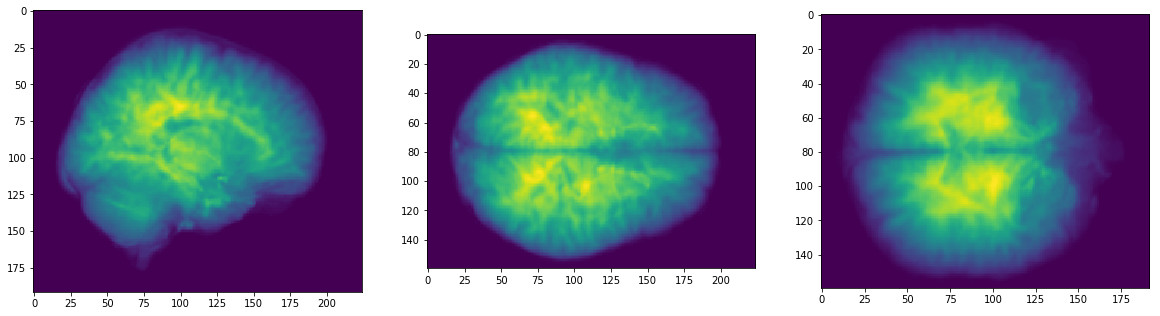

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 10))
ax1.imshow(np.mean(X_vol[0, :, :, :, 0], 0))
ax2.imshow(np.mean(X_vol[0, :, :, :, 0], 1))
ax3.imshow(np.mean(X_vol[0, :, :, :, 0], 2))

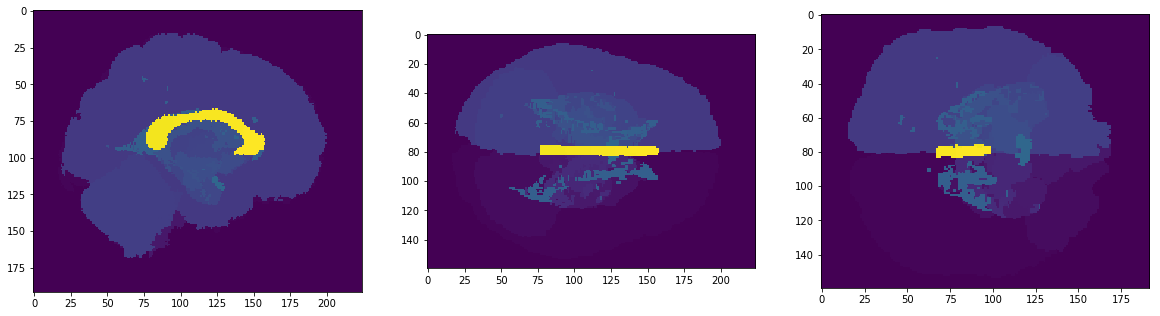

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 10))
ax1.imshow(np.max(X_seg[0, :, :, :, 0], 0))
ax2.imshow(np.max(X_seg[0, :, :, :, 0], 1))
ax3.imshow(np.max(X_seg[0, :, :, :, 0], 2))

In [14]:
%%time
pred = net.predict([X_vol, atlas_vol])

CPU times: user 1min 44s, sys: 2min 4s, total: 3min 48s
Wall time: 3min 56s


# Show Displacement Maps

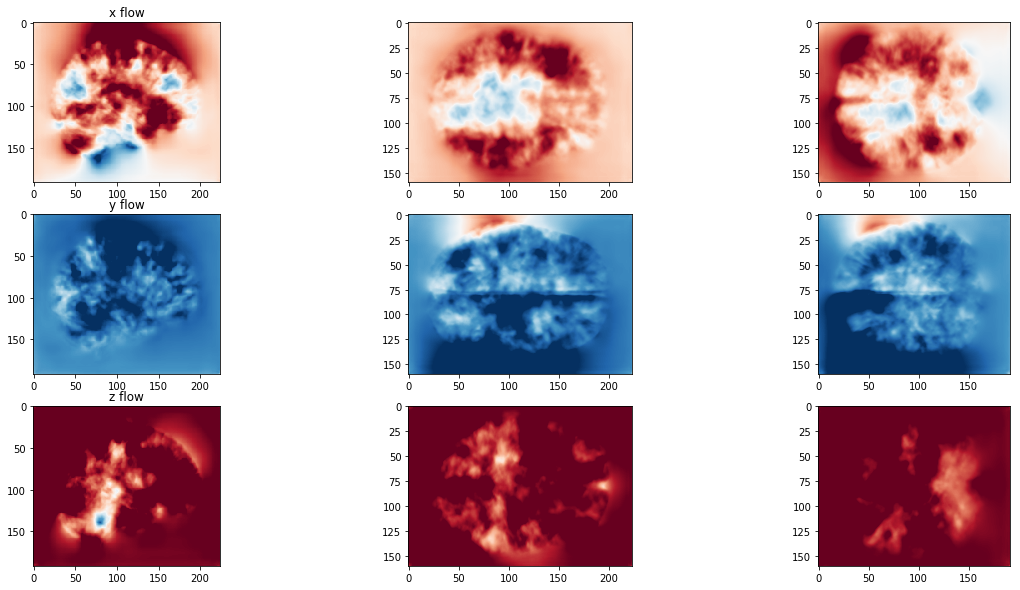

In [15]:
# Warp segments with flow
flow = pred[1][0, :, :, :, :]
flow_sd = np.std(flow)
v_args = dict(cmap = 'RdBu', vmin = -flow_sd, vmax = +flow_sd)
fig, m_axs = plt.subplots(3, 3, figsize = (20, 10))
for i, (ax1, ax2, ax3) in enumerate(m_axs):
    ax1.imshow(np.mean(flow[:, :, :, i], 0), **v_args)
    ax1.set_title('xyz'[i]+' flow')
    ax2.imshow(np.mean(flow[:, :, :, i], 1), **v_args)
    ax3.imshow(np.mean(flow[:, :, :, i], 2), **v_args)

## Show Flow Field
Here we show the flow field as a quiver map

In [16]:
def meshgridnd_like(in_img,
                    rng_func=range):
    new_shape = list(in_img.shape)
    all_range = [rng_func(i_len) for i_len in new_shape]
    return tuple([x_arr.swapaxes(0, 1) for x_arr in np.meshgrid(*all_range)])

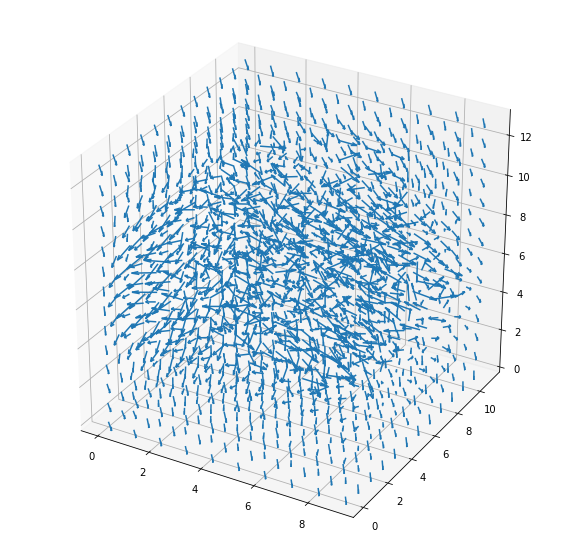

In [17]:
from mpl_toolkits.mplot3d import axes3d
DS_FACTOR = 16
c_xx, c_yy, c_zz = [x.flatten()
                    for x in 
                    meshgridnd_like(flow[::DS_FACTOR, ::DS_FACTOR, ::DS_FACTOR, 0])]

get_flow = lambda i: flow[::DS_FACTOR, ::DS_FACTOR, ::DS_FACTOR, i].flatten()

fig = plt.figure(figsize = (10, 10))
ax = fig.gca(projection='3d')

ax.quiver(c_xx,
          c_yy,
          c_zz,
          get_flow(0),
          get_flow(1), 
          get_flow(2), 
          length=0.9,
          normalize=True)

In [18]:
sample = flow+grid
sample = np.stack((sample[:, :, :, 1], sample[:, :, :, 0], sample[:, :, :, 2]), 3)
warp_seg = interpn((yy, xx, zz), X_seg[0, :, :, :, 0], sample, method='nearest', bounds_error=False, fill_value=0)
warp_vol = interpn((yy, xx, zz), X_vol[0, :, :, :, 0], sample, method='nearest', bounds_error=False, fill_value=0)

vals, _ = dice(warp_seg, atlas_seg, labels=labels, nargout=2)
print('DICE Scores for various labels:', np.mean(vals), np.std(vals))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:2514: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.values[idx_res]


DICE Scores for various labels: 0.7514045667414503 0.1394281992746137


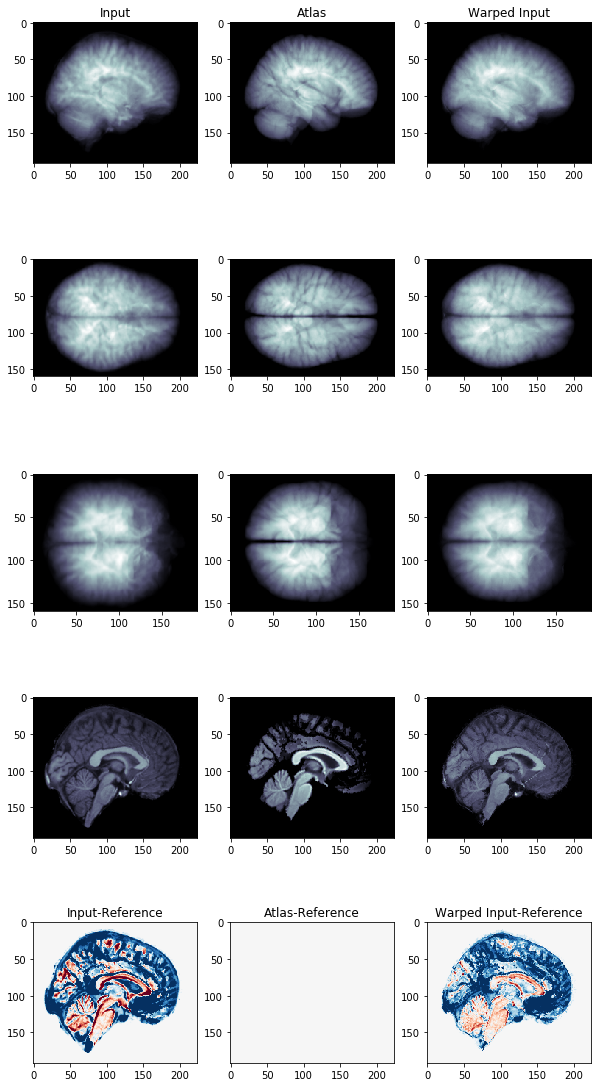

In [19]:
fig, m_axs = plt.subplots(5, 3, figsize = (10, 20))
mid_slice = X_vol.shape[1]//2
for (ax1, ax2, ax3, ax4, ax5), c_vol, c_label in zip(
    m_axs.T, 
    [X_vol, atlas_vol, np.expand_dims(np.expand_dims(warp_vol, 0), -1)], 
    ['Input', 'Atlas', 'Warped Input']
):
    ax1.imshow(np.mean(c_vol[0, :, :, :, 0], 0), cmap = 'bone')
    ax1.set_title(c_label)
    ax2.imshow(np.mean(c_vol[0, :, :, :, 0], 1), cmap = 'bone')
    ax3.imshow(np.mean(c_vol[0, :, :, :, 0], 2), cmap = 'bone')
    ax4.imshow(c_vol[0, mid_slice, :, :, 0], cmap = 'bone')
    
    ax5.imshow(c_vol[0, mid_slice, :, :, 0]-atlas_vol[0, mid_slice, :, :, 0], 
               cmap = 'RdBu', vmin = -np.std(c_vol), vmax = np.std(c_vol))
    ax5.set_title('{}-Reference'.format(c_label))

# Really Screwy Volume
We now move the volume a whole bunch manually and see if the model recovers the values it should. We create a `Y_vol` and try and register it to an `X_vol`

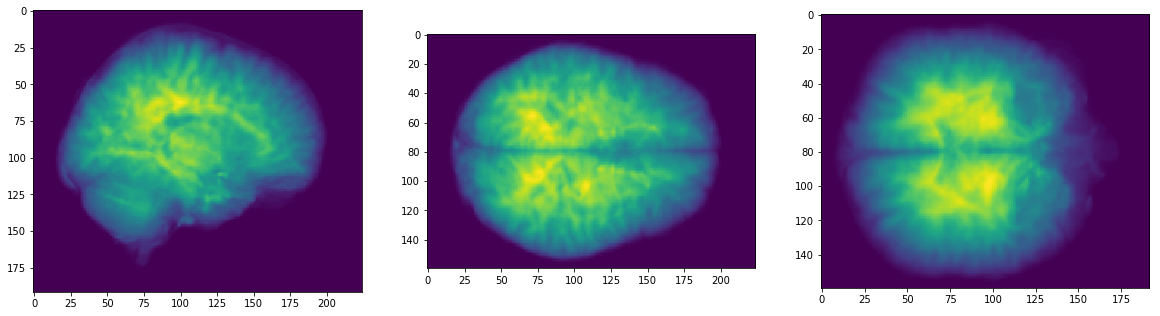

In [20]:
Y_vol = np.roll(X_vol, shift = -3, axis = 2)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 10))
ax1.imshow(np.mean(Y_vol[0, :, :, :, 0], 0))
ax2.imshow(np.mean(Y_vol[0, :, :, :, 0], 1))
ax3.imshow(np.mean(Y_vol[0, :, :, :, 0], 2))

In [21]:
%%time
pred = net.predict([Y_vol, X_vol])

CPU times: user 1min 43s, sys: 1min 46s, total: 3min 30s
Wall time: 3min 12s


In [22]:
flow = pred[1][0, :, :, :, :]
sample = flow+grid
sample = np.stack((sample[:, :, :, 1], sample[:, :, :, 0], sample[:, :, :, 2]), 3)
warp_vol = interpn((yy, xx, zz), Y_vol[0, :, :, :, 0], sample, method='nearest', bounds_error=False, fill_value=0)

In [23]:
print('Average x displacement:', np.mean(flow[:, :, :, 0]))

Average x displacement: -1.2289543


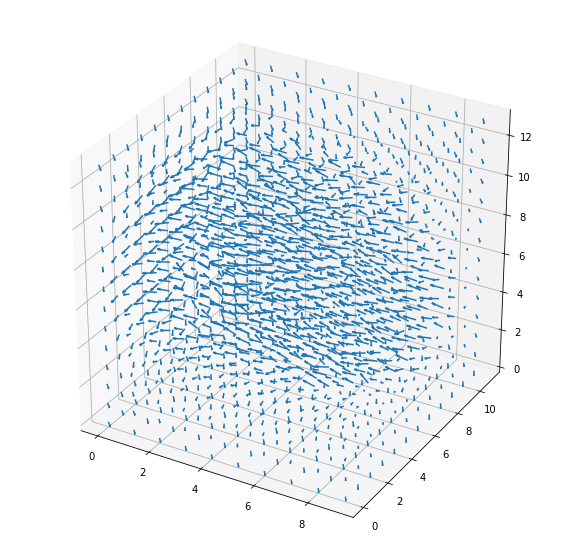

In [24]:
DS_FACTOR = 16
c_xx, c_yy, c_zz = [x.flatten()
                    for x in 
                    meshgridnd_like(flow[::DS_FACTOR, ::DS_FACTOR, ::DS_FACTOR, 0])]

get_flow = lambda i: flow[::DS_FACTOR, ::DS_FACTOR, ::DS_FACTOR, i].flatten()

fig = plt.figure(figsize = (10, 10))
ax = fig.gca(projection='3d')

ax.quiver(c_xx,
          c_yy,
          c_zz,
          get_flow(0),
          get_flow(1), 
          get_flow(2), 
          length=0.5, 
          normalize=True)

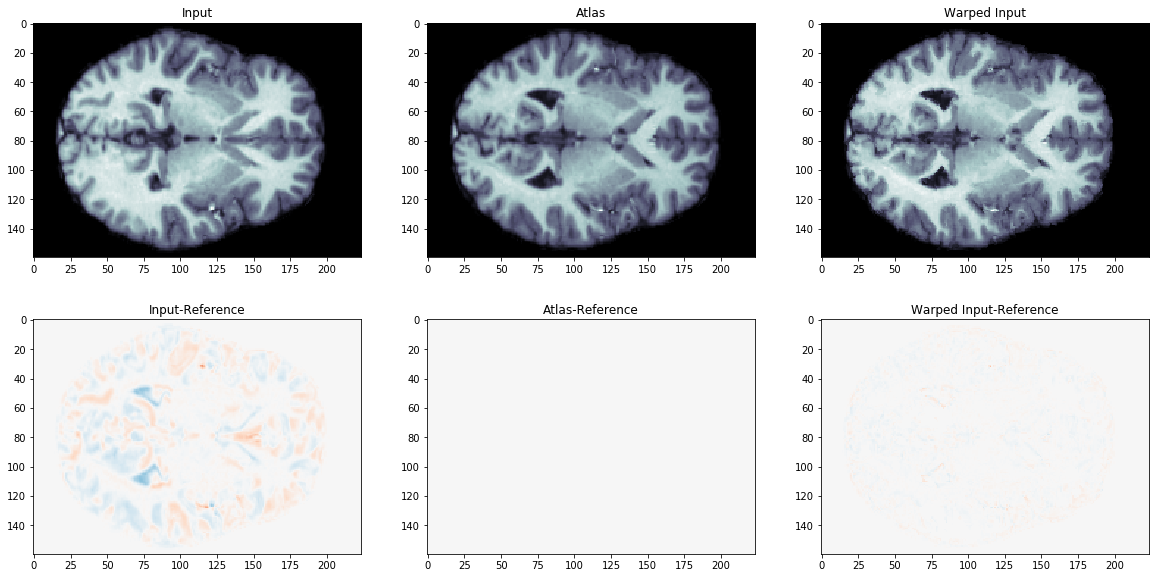

In [25]:
fig, m_axs = plt.subplots(2, 3, figsize = (20, 10))
mid_slice = X_vol.shape[2]//2
max_diff = np.max(np.abs(X_vol - Y_vol))
for (ax1, ax2), c_vol, c_label in zip(
    m_axs.T, 
    [Y_vol, X_vol, np.expand_dims(np.expand_dims(warp_vol, 0), -1)], 
    ['Input', 'Atlas', 'Warped Input']
):
    ax2.imshow(c_vol[0, :, mid_slice, :, 0] - X_vol[0, :, mid_slice, :, 0], 
               cmap = 'RdBu', vmin = -max_diff, vmax = max_diff)
    ax1.set_title(c_label)
    ax1.imshow(c_vol[0, :, mid_slice, :, 0], cmap = 'bone')
    ax2.set_title('{}-Reference'.format(c_label))